In [1]:
from _utils import *

import pickle
import numpy as np
import pandas as pd

def generate_param_pickle(
        save_file,
        save_folder,
        monomers=5000,
        replicates=6,
        lef_lifetime=10,
        lef_separation=20,
        ctcf_sites=None,
        ctcf_capture=0.5,
        ctcf_release=0.003,
        ctcf_dir=None,
        monomer_types=None,
        interaction_matrix=None,
        trajectory_length=1000,
        density=0.2,
        load_prob=1/5000,
        gpu_id="0",
        repulsion=6,
        lef_flag=True
    ):
    
    if ctcf_sites is None:
        ctcf_sites = np.arange(0, monomers, 5)
    
    ctcf_capture = np.ones_like(ctcf_sites) * ctcf_capture
    ctcf_release = np.ones_like(ctcf_sites) * ctcf_release
    load_prob = np.ones(monomers) * load_prob
    
    if ctcf_dir is None:
        ctcf_dir = np.ones_like(ctcf_sites) * 0
        
    if monomer_types is None:
        monomer_types = np.zeros(monomers, dtype=int)
        
    if interaction_matrix is None:
        interaction_matrix = np.array([[0, 0], [0, 0]])

    param_dict = {
        'monomers': monomers,
        'replicates': replicates,
        'lef_lifetime': lef_lifetime,
        'lef_separation': lef_separation,
        'ctcf_capture': ctcf_capture,
        'ctcf_release': ctcf_release,
        'save_folder': save_folder,
        'ctcf_dir': ctcf_dir,
        'ctcf_sites': ctcf_sites,
        'monomer_types': monomer_types,
        'interaction_matrix': interaction_matrix,
        'trajectory_length': trajectory_length,
        'density': density,
        'load_prob': load_prob,
        'gpu_id': gpu_id,
        'repulsion': repulsion,
        'lef_flag': True
    }
    
    with open(save_file, 'wb') as f:
        pickle.dump(param_dict, f)
    
    # change the file suffix to csv 
    save_file = save_file.split('.')
    save_file[-1] = 'csv'
    save_file = '.'.join(save_file)
    
    # save the parameters as a csv file
    # write it line by line
    with open(save_file, 'w') as f:
        for key, value in param_dict.items():
            if isinstance(value, np.ndarray):
                value = ','.join(map(str, value))
            f.write(f'{key},{value}\n')
            

save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_params'
sim_save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_results'
    

2024-10-23 14:25:03.321547: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 14:25:03.365611: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [53]:
ctcf_params_dir = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/ctcf_summary/20241023_ctcf_str_bin800.csv'
# load the ctcf parameters into a pandas dataframe
ctcf_params = pd.read_csv(ctcf_params_dir)

In [54]:
ctcf_params.head()

,bin,strand,ctcf_str_esc,ctcf_str_cnc
0,0,+,0.192175,0.592395
1,2,-,0.125078,0.649762
2,7,-,0.167537,0.683537
3,13,-,0.198379,0.565240
4,21,+,0.190887,0.584230


In [96]:
# This line ensures that there is an impermeable boundary at the end of the domain
ctcf_params.loc[len(ctcf_params)] = [max(ctcf_params['bin'])+1, '0', 1, 1]  

In [97]:
len_pattern = max(ctcf_params['bin'])

In [103]:
num_monomers = len_pattern 

In [99]:
ctcf_sites = ctcf_params['bin'].values

In [100]:
len_pattern

801

In [104]:
ctcf_sites_extended = []
for i in range(0, (num_monomers//len_pattern)+1):
    ctcf_sites_extended.extend(ctcf_sites + i*len_pattern)
ctcf_sites_extended = np.array(ctcf_sites_extended)
ctcf_sites_extended = ctcf_sites_extended[ctcf_sites_extended <= num_monomers]

In [105]:
ctcf_sites_extended

array([  0,   2,   7,  13,  21,  86, 101, 102, 104, 114, 130, 168, 192,
       196, 203, 241, 261, 274, 280, 292, 336, 339, 357, 372, 376, 377,
       381, 386, 389, 393, 401, 404, 405, 406, 410, 420, 444, 451, 479,
       483, 485, 496, 499, 500, 510, 513, 521, 527, 528, 535, 545, 567,
       574, 581, 583, 588, 593, 594, 599, 602, 610, 617, 620, 621, 630,
       631, 637, 639, 644, 662, 663, 665, 666, 667, 668, 669, 670, 672,
       679, 681, 684, 686, 690, 692, 699, 700, 701, 705, 707, 708, 711,
       712, 713, 714, 715, 716, 719, 723, 728, 737, 741, 744, 749, 752,
       753, 760, 762, 765, 766, 770, 771, 772, 787, 788, 797, 799, 800,
       801, 801])

In [106]:
ctcf_dir = ctcf_params['strand'].values
ctcf_dir[ctcf_dir == '+'] = 1
ctcf_dir[ctcf_dir == '-'] = 2
ctcf_dir[ctcf_dir == '0'] = 0

In [107]:
num_ctcf = len(ctcf_sites_extended)
ctcf_dir_extended = np.tile(ctcf_dir, num_monomers//len_pattern+1)
ctcf_dir_extended = ctcf_dir_extended[:num_ctcf]

In [108]:
ctcf_capture_esc = ctcf_params['ctcf_str_esc'].values
ctcf_capture_esc_extended = np.tile(ctcf_capture_esc, num_monomers//len_pattern+1)
ctcf_capture_esc_extended = ctcf_capture_esc_extended[:num_ctcf]

In [109]:
ctcf_capture_cnc = ctcf_params['ctcf_str_cnc'].values
ctcf_capture_cnc_extended = np.tile(ctcf_capture_cnc, num_monomers//len_pattern+1)
ctcf_capture_cnc_extended = ctcf_capture_cnc_extended[:num_ctcf]

In [111]:
len(ctcf_sites_extended), len(ctcf_dir_extended), len(ctcf_capture_esc_extended), len(ctcf_capture_cnc_extended)

(119, 119, 119, 119)

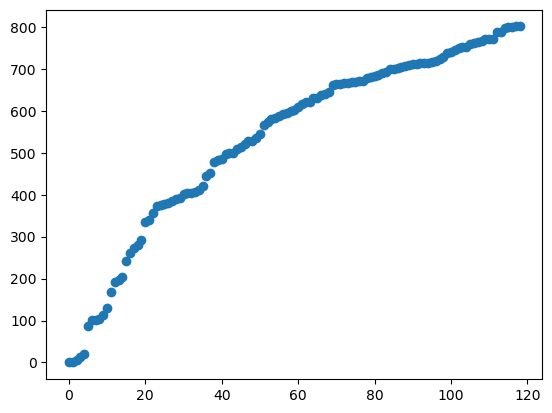

In [112]:
plt.plot(ctcf_sites_extended[:200], 'o')

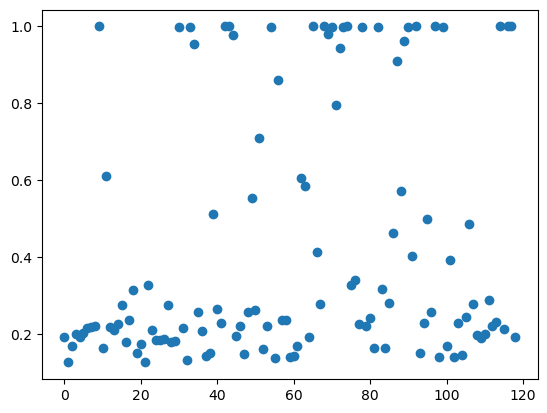

In [113]:
plt.plot(ctcf_capture_esc_extended[:200], 'o')

In [114]:
generate_param_pickle(
    f'{save_dir}/20241023_Sox9_esc_BEend_BEstronger_Monomers800.pkl',
    f'{sim_save_dir}/20241023_Sox9_esc_BEend_BEstronger_Monomers800/',
    ctcf_sites=ctcf_sites_extended,
    ctcf_capture=ctcf_capture_esc_extended,
    ctcf_dir=ctcf_dir_extended,
    monomers=num_monomers,
    trajectory_length=1000
)

In [115]:
generate_param_pickle(
    f'{save_dir}/20241023_Sox9_cnc_BEend_BEstronger_Monomers800.pkl',
    f'{sim_save_dir}/20241023_Sox9_cnc_BEend_BEstronger_Monomers800/',
    ctcf_sites=ctcf_sites_extended,
    ctcf_capture=ctcf_capture_cnc_extended,
    ctcf_dir=ctcf_dir_extended,
    trajectory_length=1000,
    monomers=num_monomers
)

In [ ]:
# need to introduce impermeable CTCF boundary between domain

In [116]:
# Run sbatch script
slurm_path = '/mnt/home/tudomlumleart/ceph/12_LoopQuantification/scripts/slurm/2024_RunPythonScriptOpenMM.sh'
python_path = '/mnt/home/tudomlumleart/ceph/12_LoopQuantification/scripts/polymer_simulation.py'
params_path = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_params'

# Find file in params that start with 20241010 and ends with .pkl
import glob
import os

matching_files = glob.glob(f'{params_path}/20241023_Sox9*BEend_BEstronger_Monomers800.pkl')

# Iterate through all matching files 
for file in matching_files:
    print(file)
    # run sbatch script
    os.system(f'sbatch {slurm_path} {python_path} {file}')


/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_params/20241023_Sox9_cnc_BEend_BEstronger_Monomers800.pkl
Submitted batch job 4087494
/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/md_params/20241023_Sox9_esc_BEend_BEstronger_Monomers800.pkl
Submitted batch job 4087495
